## Imports

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from skimage.segmentation import disk_level_set
import os

## Paths

In [3]:
IMG_PATH = r'C:/Users/ginof/OneDrive - ITU/Documentos/GitHub/fyp2021p3g03/data/example_image/'
SEG_PATH = r'C:/Users/ginof/OneDrive - ITU/Documentos/GitHub/fyp2021p3g03/data/example_segmentation/'

TRUTH = 'fyp2021p3g03/data/example_ground_truth.csv'
FEATURES = 'fyp2021p3g03/features/features.csv'

## Import single image and create mask

In [4]:
image = plt.imread(SEG_PATH+'ISIC_0001769_segmentation.png')

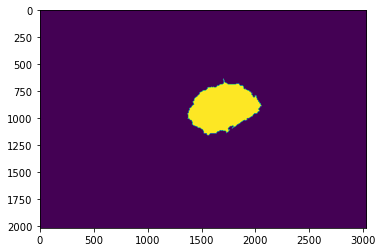

In [85]:
plt.imshow(image)

In [175]:
def get_boundaries(image):
    mask = np.where(image == 1)
    left = min(mask[1])
    right = max(mask[1])
    upper = min(mask[0])
    lower = max(mask[0])
    return upper, lower, left, right

def get_center(image): # NOT NEEDED ANYMORE ?
    up, dw, lt, rt = get_boundaries(image)
    center = ((up+dw)/2, (lt+rt)/2)
    return center
    
def zoom(image):
    up, dw, lt, rt = get_boundaries(image)
    rectangle = image[up:dw+1, lt:rt+1]
    return rectangle

def cuts(image):

    center_h = image.shape[0] // 2
    if image.shape[0] % 2 == 0:
        upside = image[:center_h,:]
        downside = image[center_h:,:]
    else:
        upside = image[:center_h+1,:]
        downside = image[center_h:,:]
        
    center_w = image.shape[1] // 2    
    if image.shape[1] % 2 == 0:
        leftside = image[:,:center_w]
        rightside = image[:,center_w:]
    else:
        leftside = image[:,:center_w+1]
        rightside = image[:,center_w:]
 
    return upside, downside, leftside, rightside


def test_symmetry(image, show=False):

    symmetries = []
    
    for deg in range(0,90, 30):
        rot_image = skimage.transform.rotate(image, deg)
        z = zoom(rot_image)
        
        upside, downside, leftside, rightside = cuts(z)

        up_dw = np.sum(np.bitwise_and(upside.astype(int), np.flipud(downside).astype(int))) /\
        np.sum(np.bitwise_or(upside.astype(int), np.flipud(downside).astype(int)))

        lt_rt = np.sum(np.bitwise_and(leftside.astype(int), np.fliplr(rightside).astype(int))) /\
        np.sum(np.bitwise_or(leftside.astype(int), np.fliplr(rightside).astype(int)))
    
        symmetries.append((up_dw+lt_rt)/2)
    
    symmetry = max(symmetries)

    return symmetry
    


(521, 688)

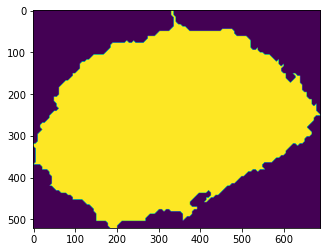

In [119]:
z = zoom(image)
a, b, c, d = cuts(z)
plt.imshow(z)
z.shape

(521, 344)

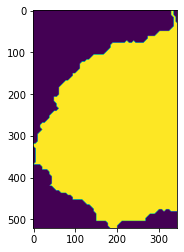

In [120]:
plt.imshow(c)
c.shape


(521, 344)

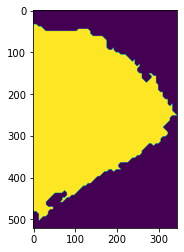

In [121]:
plt.imshow(d)
d.shape

In [122]:
symmetries = {}
for f in os.listdir(SEG_PATH)[:10]:
    if f.endswith('.png'):
        image = plt.imread(SEG_PATH+f)
        symmetries[f] = test_symmetry(image)
    

In [123]:
symmetries

{'ISIC_0001769_segmentation.png': 0.7602783631655298,
 'ISIC_0001852_segmentation.png': 0.8449745698036415,
 'ISIC_0001871_segmentation.png': 0.9168436112478937,
 'ISIC_0003462_segmentation.png': 0.9252754206504514,
 'ISIC_0003539_segmentation.png': 0.7277153165857638,
 'ISIC_0003582_segmentation.png': 0.8198538836056453,
 'ISIC_0003657_segmentation.png': 0.864792539195022,
 'ISIC_0003805_segmentation.png': 0.8406930951259688,
 'ISIC_0004337_segmentation.png': 0.9205542882473023}

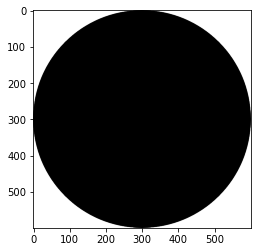

In [165]:
test = plt.imread(SEG_PATH+'test-black-circle.png')
plt.imshow(test)

In [169]:
test_symmetry(test)

1.0

In [178]:
symmetries = {}
for f in os.listdir(SEG_PATH):
    if f.endswith('.png'):
        image = plt.imread(SEG_PATH+f)
        symmetries[f] = test_symmetry(image)
    

In [179]:
symmetries

{'ISIC_0001769_segmentation.png': 0.7602783631655298,
 'ISIC_0001852_segmentation.png': 0.8449745698036415,
 'ISIC_0001871_segmentation.png': 0.9168436112478937,
 'ISIC_0003462_segmentation.png': 0.9252754206504514,
 'ISIC_0003539_segmentation.png': 0.7277153165857638,
 'ISIC_0003582_segmentation.png': 0.8198538836056453,
 'ISIC_0003657_segmentation.png': 0.864792539195022,
 'ISIC_0003805_segmentation.png': 0.8406930951259688,
 'ISIC_0004337_segmentation.png': 0.9205542882473023,
 'ISIC_0006651_segmentation.png': 0.9180263534813962,
 'ISIC_0006671_segmentation.png': 0.8696323835877813,
 'ISIC_0006815_segmentation.png': 0.7945483932515154,
 'ISIC_0006914_segmentation.png': 0.873959001338855,
 'ISIC_0007141_segmentation.png': 0.9376931340956733,
 'ISIC_0007156_segmentation.png': 0.9426058488319671,
 'ISIC_0007235_segmentation.png': 0.9296713438859887,
 'ISIC_0007241_segmentation.png': 0.8288205586947341,
 'ISIC_0007332_segmentation.png': 0.908944568896474,
 'ISIC_0007344_segmentation.png

In [184]:
with open("symmetry_results.csv", 'w') as outfile:
    for k, v in symmetries.items():
        line = str(k) + "\t" + str(v) + "\n"
        outfile.write(line)